

## Energy Optimization Model Formulation

**Indices**  
- $t \in \{1, 2, \dots, 24\}$: Time periods (hours of a day).

**Parameters**  
- $\text{PRC}_t$: Electricity price at time $t$ (\$/kWh).  
- $P^{\text{PV}}_t$: Photovoltaic power generation at time $t$ (kW).  
- $P^{\text{load}}_t$: Load demand at time $t$ (kW).  
- $\text{ExCap}^{\text{Grid}}$: Maximum grid exchange capacity (kW).  
- $P^{\text{MaxCharge}}$: Maximum battery charging rate (kW).  
- $P^{\text{MaxDischarge}}$: Maximum battery discharging rate (kW).  
- $\text{Cap}^{\text{Bat}}$: Battery capacity (kWh).  
- $\eta^{\text{charge}}$: Battery charging efficiency.  
- $\eta^{\text{discharge}}$: Battery discharging efficiency.

**Decision Variables**  
- $\color{green}{P^{\text{import}}_t} \in [0, \text{ExCap}^{\text{Grid}})$: Power imported from the grid at time $t$ (kW).  
- $\color{green}{P^{\text{export}}_t} \in [0, \text{ExCap}^{\text{Grid}})$: Power exported to the grid at time $t$ (kW).  
- $\color{green}{P^{\text{charge}}_t} \in [0, P^{\text{MaxCharge}}]$: Battery charging power at time $t$ (kW).  
- $\color{green}{P^{\text{discharge}}_t} \in [0, P^{\text{MaxDischarge}}]$: Battery discharging power at time $t$ (kW).  
- $\color{green}{B^{\text{import}}_t} \in \{0, 1\}$: Indicator for importing power at time $t$ (1 if importing, 0 otherwise).  
- $\color{green}{B^{\text{export}}_t} \in \{0, 1\}$: Indicator for exporting power at time $t$ (1 if exporting, 0 otherwise).  
- $\color{green}{B^{\text{charge}}_t} \in \{0, 1\}$: Indicator for battery charging at time $t$ (1 if charging, 0 otherwise).  
- $\color{green}{B^{\text{discharge}}_t} \in \{0, 1\}$: Indicator for battery discharging at time $t$ (1 if discharging, 0 otherwise).  

**Dependent Variables**  
- $\color{blue}{\text{SOE}^{\text{Bat}}_t} \in [0, \text{Cap}^{\text{Bat}}]$: Battery state of charge at time $t$ (kWh).





#------------------------------------------------------------------------

**Objective Function**  
Minimize the net electricity cost:  
$$
\min \sum_{t=1}^{24} \text{PRC}_t \cdot (\color{green}{P^{\text{import}}_t} - \color{green}{P^{\text{export}}_t})
$$

**Constraints**  
For all $t \in \{1, 2, \dots, 24\}$ unless specified:  

1. **Power Balance**:  
$$
\color{green}{P^{\text{import}}_t} + \color{green}{P^{\text{discharge}}_t} + P^{\text{PV}}_t = \color{green}{P^{\text{export}}_t} + \color{green}{P^{\text{charge}}_t} + P^{\text{load}}_t
$$

2. **Grid Interaction Limits**:  
$$
\color{green}{P^{\text{import}}_t} \leq \text{ExCap}^{\text{Grid}} \cdot \color{green}{B^{\text{import}}_t}
$$  
$$
\color{green}{P^{\text{export}}_t} \leq \text{ExCap}^{\text{Grid}} \cdot \color{green}{B^{\text{export}}_t}
$$  
$$
\color{green}{B^{\text{import}}_t} + \color{green}{B^{\text{export}}_t} \leq 1
$$

3. **Battery State of Charge**:  
$$
\color{blue}{\text{SOE}^{\text{Bat}}_t} =
\begin{cases}
\color{blue}{\text{SOE}^{\text{initial}}_{t1}}, & \text{if } t = 1 \\
\color{blue}{\text{SOE}^{\text{Bat}}_{t-1}} + \eta^{\text{charge}} \cdot \color{green}{P^{\text{charge}}_t} - \frac{\color{green}{P^{\text{discharge}}_t}}{\eta^{\text{discharge}}}, & \text{if } t \geq 2
\end{cases}
$$

4. **Battery Operation Limits**:  
$$
\color{green}{P^{\text{charge}}_t} \leq P^{\text{MaxCharge}} \cdot \color{green}{B^{\text{charge}}_t}
$$  
$$
\color{green}{P^{\text{discharge}}_t} \leq P^{\text{MaxDischarge}} \cdot \color{green}{B^{\text{discharge}}_t}
$$  
$$
\color{green}{B^{\text{charge}}_t} + \color{green}{B^{\text{discharge}}_t} \leq 1
$$

5. **Final Battery State**:  
$$
\color{blue}{\text{SOE}^{\text{Bat}}_{t24}} = \color{blue}{\text{SOE}^{\text{Bat}}_{t1}}
$$

In [1]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 25.2 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import gurobipy as gp
import matplotlib.pyplot as plt
import time

In [3]:
## Importing data from google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.15381665601273428, 6: 0.7718877908769429, 7: 1.7648762539947571, 8: 2.985067275731443, 9: 3.955205844656214, 10: 4.677265210294, 11: 5.014963946234985, 12: 4.950553031164629, 13: 4.5325665427121145, 14: 3.703880121978057, 15: 2.658715792112143, 16: 1.5148610021054714, 17: 0.6441573024578201, 18: 0.13764972220945915, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0}


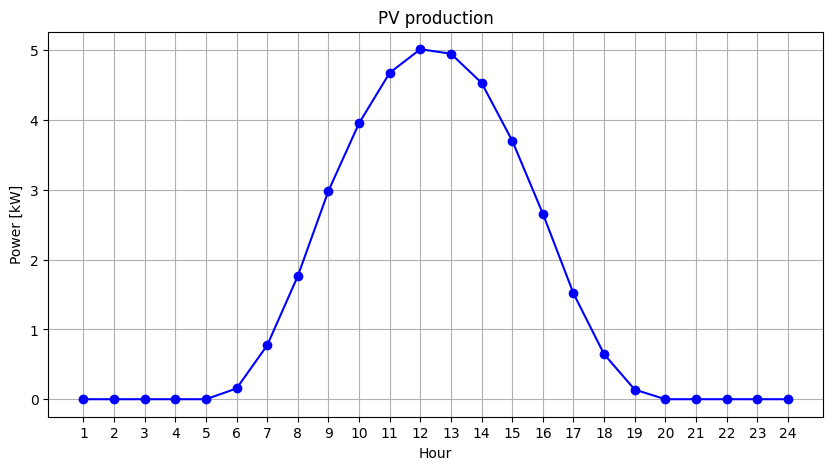

In [25]:
# Read the Excel file "Data1.xlsx" into a Pandas DataFrame called "PV"
# Specifically, read from the sheet named "PVD"
# Use columns A through X (inclusive)
# Assume the header is in the first row (index 0)
# Read only the first row (nrows=1)
PV = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Data1.xlsx", sheet_name="PVD", usecols="A:X", header=0, nrows=1)


PV = PV.iloc[0].to_dict()  # Convert first row to dictionary
PV = {i: PV[f"t{i+1}"] for i in range(24)}  # Rename keys from 't1'-'t24' to 0-23
print(PV)

# ✅ Convert to NumPy array
values = np.array(list(PV.values()))  # Extract values
x_labels = np.arange(1, 25)  # 1 to 24

# ✅ Plot
plt.figure(figsize=(10, 5))
plt.plot(x_labels, values, marker='o', linestyle='-', color='b', label="Profile")

# ✅ Customize plot
plt.xlabel("Hour")
plt.ylabel("Power [kW]")
plt.title("PV production")
plt.xticks(x_labels)
#plt.legend()
plt.grid(True)

# ✅ Show plot
plt.show()

{0: 1.1, 1: 0.9, 2: 1.5, 3: 2.0, 4: 2.7, 5: 2.9, 6: 3.2, 7: 3.0, 8: 2.4, 9: 2.0, 10: 1.8, 11: 1.5, 12: 1.8, 13: 2.4, 14: 3.1, 15: 3.4, 16: 3.8, 17: 3.85, 18: 3.8, 19: 3.6, 20: 3.1, 21: 2.5, 22: 1.7, 23: 1.3}


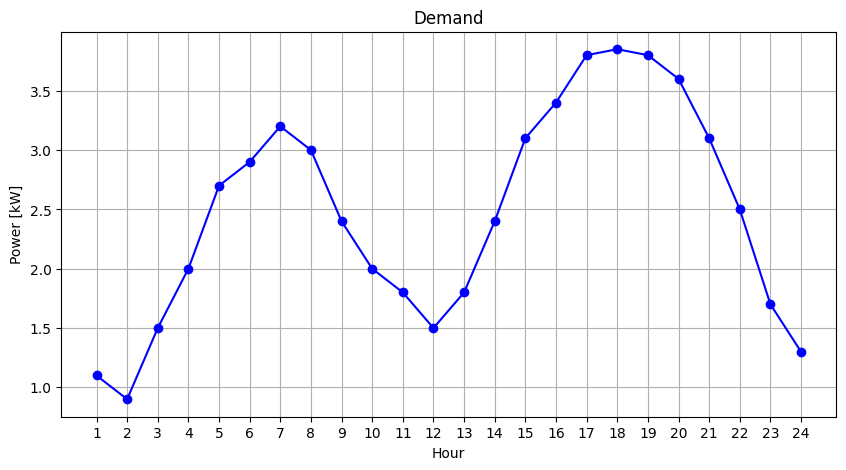

In [5]:
## Preparing demands profile

PL = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Data1.xlsx", sheet_name="Det_ld", usecols="A:X", header=0, nrows=1)


PL = PL.iloc[0].to_dict()  # Convert first row to dictionary
PL = {i: PL[f"t{i+1}"] for i in range(24)}  # Rename keys from 't1'-'t24' to 0-23
print(PL)

# ✅ Convert to NumPy array
values = np.array(list(PL.values()))  # Extract values
x_labels = np.arange(1, 25)  # 1 to 24

# ✅ Plot
plt.figure(figsize=(10, 5))
plt.plot(x_labels, values, marker='o', linestyle='-', color='b', label="Profile")

# ✅ Customize plot
plt.xlabel("Hour")
plt.ylabel("Power [kW]")
plt.title("Demand")
plt.xticks(x_labels)
#plt.legend()
plt.grid(True)

# ✅ Show plot
plt.show()

{0: 0.33326887687737056, 1: 0.33326887687737056, 2: 0.33326887687737056, 3: 0.33326887687737056, 4: 0.33326887687737056, 5: 0.33326887687737056, 6: 0.33326887687737056, 7: 0.5516653116779644, 8: 0.5516653116779644, 9: 0.5516653116779644, 10: 0.5516653116779644, 11: 0.7473972284458312, 12: 0.7473972284458312, 13: 0.7473972284458312, 14: 0.5516653116779644, 15: 0.5516653116779644, 16: 0.5516653116779644, 17: 0.5516653116779644, 18: 0.7473972284458312, 19: 0.7473972284458312, 20: 0.7473972284458312, 21: 0.7473972284458312, 22: 0.33326887687737056, 23: 0.33326887687737056}


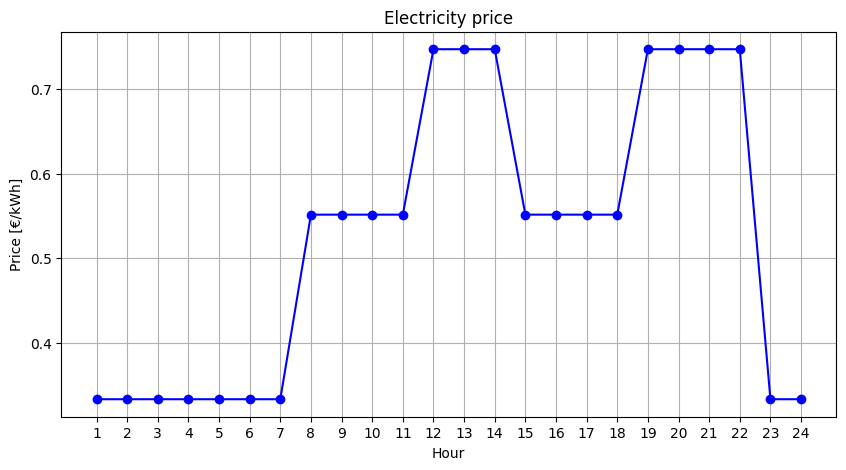

In [6]:
## Preparing price profiles

PRC = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Data1.xlsx", sheet_name="Price", usecols="A:X", header=0, nrows=1)


PRC = PRC.iloc[0].to_dict()  # Convert first row to dictionary
PRC = {i: PRC[f"t{i+1}"] for i in range(24)}  # Rename keys from 't1'-'t24' to 0-23
print(PRC)

# ✅ Convert to NumPy array
values = np.array(list(PRC.values()))  # Extract values
x_labels = np.arange(1, 25)  # 1 to 24

# ✅ Plot
plt.figure(figsize=(10, 5))
plt.plot(x_labels, values, marker='o', linestyle='-', color='b', label="Profile")

# ✅ Customize plot
plt.xlabel("Hour")
plt.ylabel("Price [€/kWh]")
plt.title("Electricity price")
plt.xticks(x_labels)
#plt.legend()
plt.grid(True)

# ✅ Show plot
plt.show()

In [26]:
## ESS
battery_capacity = 10.0  # kWh
charging_rate = 1.0      # kW
discharging_rate = 1.0   # kW

In [27]:
## Grid
Exch_grid = 10         # Grid exchange limit

In [28]:
# Define time periods (e.g., hours of the day)
time_periods = range(24)


# Initialize Gurobi Model
model = gp.Model("Energy_Optimization")

# Decision Variables
PinG = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=1000000, name="PinG")
PexG = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=1000000, name="PexG")
Bin_gi = model.addVars(time_periods, vtype=gp.GRB.BINARY, name="Bin_gi")
Bin_go = model.addVars(time_periods, vtype=gp.GRB.BINARY, name="Bin_go")

charge = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=charging_rate, name="charge")
Bin_cess = model.addVars(time_periods, vtype=gp.GRB.BINARY, name="Bin_cess")
discharge = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=discharging_rate, name="discharge")
Bin_dess = model.addVars(time_periods, vtype=gp.GRB.BINARY, name="Bin_dess")
battery_level = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=battery_capacity, name="battery_level")

In [29]:
# Define a range of 24 time periods, representing hours in a day
time_periods = range(24)

# Create a new Gurobi optimization model named "Energy_Optimization"
model = gp.Model("Energy_Optimization")

#Define Variables

#Energy Exchange variables
# continuous vars
# Add continuous variables for power imported from the grid, bounded between 0 and 10
PinG = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=Exch_grid, name="PinG")
# Add continuous variables for power exported to the grid, bounded between 0 and 10
PexG = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=Exch_grid, name="PexG")
# binariy vars
# Add binary variables to indicate whether power is imported from the grid (1 if importing, 0 otherwise)
Bin_gi = model.addVars(time_periods, vtype=gp.GRB.BINARY, name="Bin_gi")
# Add binary variables to indicate whether power is exported to the grid (1 if exporting, 0 otherwise)
Bin_go = model.addVars(time_periods, vtype=gp.GRB.BINARY, name="Bin_go")

#Battery storage variables
# Add continuous variables for battery charging rate, bounded between 0 and a predefined charging_rate
charge = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=charging_rate, name="charge")
# Add binary variables to indicate whether the battery is charging (1 if charging, 0 otherwise)
Bin_cess = model.addVars(time_periods, vtype=gp.GRB.BINARY, name="Bin_cess")

# Add continuous variables for battery discharging rate, bounded between 0 and a predefined discharging_rate
discharge = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=discharging_rate, name="discharge")
# Add binary variables to indicate whether the battery is discharging (1 if discharging, 0 otherwise)
Bin_dess = model.addVars(time_periods, vtype=gp.GRB.BINARY, name="Bin_dess")

# Add continuous variables for battery state of charge, bounded between 0 and a predefined battery_capacity
battery_level = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=battery_capacity, name="battery_level")

In [30]:
# Objective Function: Minimizing Electricity bill
model.setObjective(
    gp.quicksum(PRC[t] * (PinG[t] - PexG[t]) for t in range(24)),
    gp.GRB.MINIMIZE
)

In [31]:
# Constraints
for t in time_periods:
    # Energy balance constraint
    model.addConstr(PinG[t] + discharge[t] + PV[t] == PexG[t] +charge[t] + PL[t])

    # Exchanging energy constraint
    model.addConstr(PinG[t] <= Exch_grid * Bin_gi[t])
    model.addConstr(PexG[t] <= Exch_grid * Bin_go[t])
    model.addConstr(Bin_gi[t] + Bin_go[t] <= 1)

# Battery energy balance constraint
    if t == 0:
        model.addConstr(battery_level[t] == 0.5 * battery_capacity)  # Initial battery level
    else:
        model.addConstr(battery_level[t] == battery_level[t - 1] + (charge[t] * 0.95) - (discharge[t] / 0.95))

    # Ensure final SoE is equal to initial SoE (Fix t == 23 instead of t == 24)
    if t == 23:
        model.addConstr(battery_level[t] == 0.5 * battery_capacity)  # Final battery level same as initial


    # Battery charging and discharging constraints
    model.addConstr(charge[t] <= charging_rate * Bin_cess[t])
    model.addConstr(discharge[t] <= discharging_rate * Bin_dess[t])
    model.addConstr(Bin_cess[t] + Bin_dess[t] <= 1)

In [32]:
# Solve Optimization Problem
model.optimize()

# Check Solver Status
if model.status == gp.GRB.OPTIMAL:
    print(f"Optimized Total Cost: {model.objVal}")
    for t in time_periods:
        print(f"Time {t}: Charge={charge[t].X}, Discharge={discharge[t].X}, Battery Level={battery_level[t].X}")
else:
    print("Optimization did not converge.")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 193 rows, 216 columns and 478 nonzeros
Model fingerprint: 0xdf940840
Variable types: 120 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+01]
  Objective range  [3e-01, 7e-01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [6e-01, 5e+00]
Found heuristic solution: objective 9.2923569
Presolve removed 120 rows and 121 columns
Presolve time: 0.00s
Presolved: 73 rows, 95 columns, 198 nonzeros
Found heuristic solution: objective 8.9590881
Variable types: 68 continuous, 27 integer (27 binary)

Root relaxation: objective 6.419904e+00, 34 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 193 rows, 216 columns and 478 nonzeros
Model fingerprint: 0xdf940840
Variable types: 120 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+01]
  Objective range  [3e-01, 7e-01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [6e-01, 5e+00]
Presolved: 73 rows, 95 columns, 198 nonzeros

Continuing optimization...


Explored 1 nodes (34 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 2 (of 2 available processors)

Solution count 3: 6.4199 8.95909 9.29236 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.419904206993e+00, best bound 6.419904206993e+00, gap 0.0000%


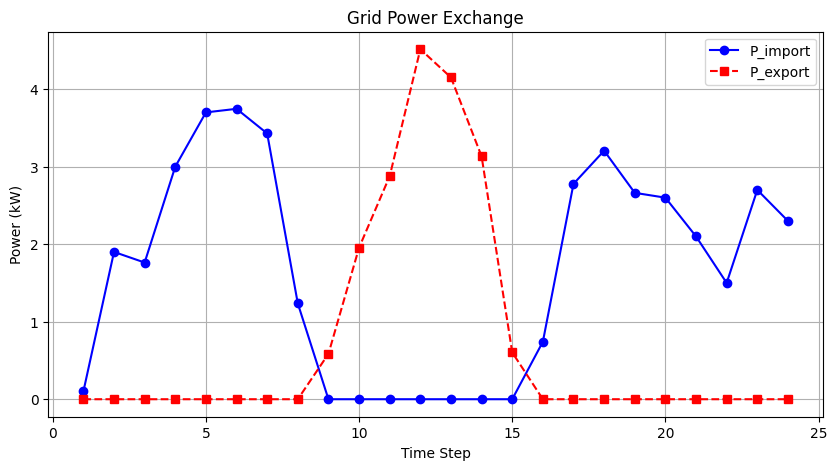

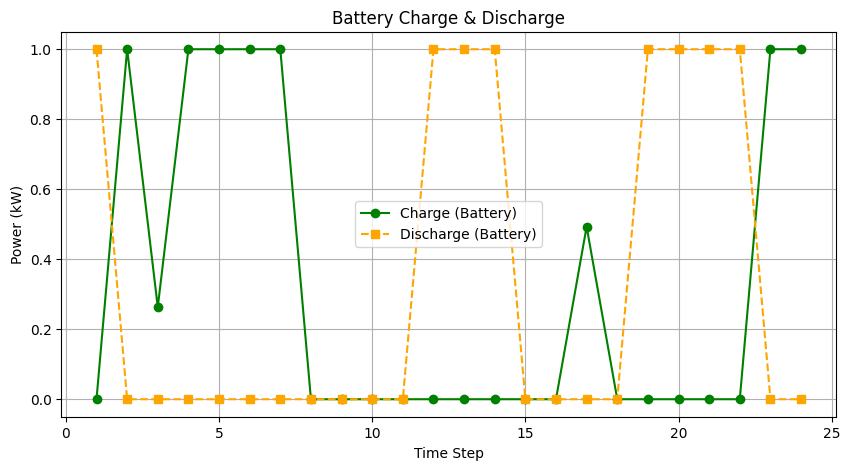

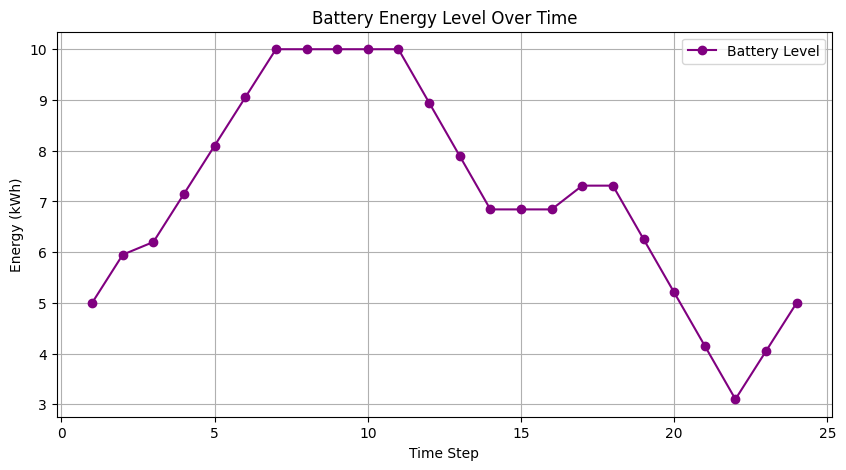

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp

# ✅ Solve the model before plotting
model.optimize()

# ✅ Extract Decision Variable Values from Gurobi Model
PinG_values = [PinG[t].X for t in time_periods]  # Power input from grid
PexG_values = [PexG[t].X for t in time_periods]  # Power exported to grid
charge_values = [charge[t].X for t in time_periods]  # Battery charge
discharge_values = [discharge[t].X for t in time_periods]  # Battery discharge
battery_level_values = [battery_level[t].X for t in time_periods]  # Battery level

x_labels = np.arange(1, 25)  # Time periods 1 to 24

# ✅ 1st Figure: Grid Power Exchange
plt.figure(figsize=(10, 5))
plt.plot(x_labels, PinG_values, marker='o', linestyle='-', color='b', label="P_import")
plt.plot(x_labels, PexG_values, marker='s', linestyle='--', color='r', label="P_export")
plt.xlabel("Time Step")
plt.ylabel("Power (kW)")
plt.title("Grid Power Exchange")
plt.legend()
plt.grid(True)
plt.show()

# ✅ 2nd Figure: Battery Charging & Discharging
plt.figure(figsize=(10, 5))
plt.plot(x_labels, charge_values, marker='o', linestyle='-', color='g', label="Charge (Battery)")
plt.plot(x_labels, discharge_values, marker='s', linestyle='--', color='orange', label="Discharge (Battery)")
plt.xlabel("Time Step")
plt.ylabel("Power (kW)")
plt.title("Battery Charge & Discharge")
plt.legend()
plt.grid(True)
plt.show()

# ✅ 3rd Figure: Battery Energy Level Over Time
plt.figure(figsize=(10, 5))
plt.plot(x_labels, battery_level_values, marker='o', linestyle='-', color='purple', label="Battery Level")
plt.xlabel("Time Step")
plt.ylabel("Energy (kWh)")
plt.title("Battery Energy Level Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [36]:
# Objective Function: Minimize Total Cost
model.setObjective(
    gp.quicksum(PRC[t] * (PinG[t] - PexG[t]) for t in range(24)),
    gp.GRB.MINIMIZE
)

In [37]:
# Constraints
for t in time_periods:
    # Energy balance constraint
    model.addConstr(PinG[t] + discharge[t] + PV[t] == PexG[t] +charge[t] + PL[t])

    # Exchanging energy constraint
    model.addConstr(PinG[t] <= Exch_grid * Bin_gi[t])
    model.addConstr(PexG[t] <= Exch_grid * Bin_go[t])
    model.addConstr(Bin_gi[t] + Bin_go[t] <= 1)

# Battery energy balance constraint
    if t == 0:
        model.addConstr(battery_level[t] == 0.5 * battery_capacity)  # Initial battery level
    else:
        model.addConstr(battery_level[t] == battery_level[t - 1] + (charge[t] * 0.95) - (discharge[t] / 0.95))

    # Ensure final SoE is equal to initial SoE (Fix t == 23 instead of t == 24)
    if t == 23:
        model.addConstr(battery_level[t] == 0.5 * battery_capacity)  # Final battery level same as initial


    # Battery charging and discharging constraints
    model.addConstr(charge[t] <= charging_rate * Bin_cess[t])
    model.addConstr(discharge[t] <= discharging_rate * Bin_dess[t])
    model.addConstr(Bin_cess[t] + Bin_dess[t] <= 1)

In [38]:
# Solve Optimization Problem
model.optimize()

# Check Solver Status
if model.status == gp.GRB.OPTIMAL:
    print(f"Optimized Total Cost: {model.objVal}")
else:
    print("Optimization did not converge.")

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 386 rows, 216 columns and 956 nonzeros
Model fingerprint: 0xd293c780
Variable types: 120 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+01]
  Objective range  [3e-01, 7e-01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [6e-01, 5e+00]

MIP start from previous solve produced solution with objective 6.4199 (0.01s)
MIP start from previous solve produced solution with objective 6.4199 (0.01s)
Loaded MIP start from previous solve with objective 6.4199

Presolve removed 313 rows and 121 columns
Presolve time: 0.00s
Presolved: 73 rows, 95 columns, 198 nonzeros
Variable types: 68 continuous, 27 integer (27 binary)

Root relaxation: cutoff, 50 iterations, 0.00 seconds (0.00 work units)

    Nod

In [39]:
# Define the range of charging and discharging rates to test
charging_rates = np.linspace(1.0, 5.0, 5)  # Charging rate from 1 to 5 kW (5 steps)
discharging_rates = np.linspace(1.0, 5.0, 5)  # Discharging rate from 1 to 5 kW (5 steps)

# Store results
results = []

# Loop through different charging & discharging rates
for charge_rate in charging_rates:
    for discharge_rate in discharging_rates:

        # ✅ Update the battery charge and discharge rate limits in the model
        for t in time_periods:
            charge[t].ub = charge_rate  # Update charging rate upper bound
            discharge[t].ub = discharge_rate  # Update discharging rate upper bound

        # ✅ Solve the updated optimization model
        model.optimize()

        # ✅ Check Solver Status
        if model.status == gp.GRB.OPTIMAL:
            print(f"✅ Optimized Total Cost: {model.objVal} for Charge Rate = {charge_rate}, Discharge Rate = {discharge_rate}")
            results.append((charge_rate, discharge_rate, model.objVal))
        else:
            print(f"⚠️ Optimization did not converge for Charge Rate = {charge_rate}, Discharge Rate = {discharge_rate}")


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 386 rows, 216 columns and 956 nonzeros
Model fingerprint: 0xd293c780
Variable types: 120 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+01]
  Objective range  [3e-01, 7e-01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [6e-01, 5e+00]

MIP start from previous solve produced solution with objective 6.4199 (0.01s)
MIP start from previous solve produced solution with objective 6.4199 (0.01s)
Loaded MIP start from previous solve with objective 6.4199

Presolve removed 313 rows and 121 columns
Presolve time: 0.00s
Presolved: 73 rows, 95 columns, 198 nonzeros
Variable types: 68 continuous, 27 integer (27 binary)

Root relaxation: cutoff, 50 iterations, 0.00 seconds (0.00 work units)

    Nod

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 386 rows, 216 columns and 956 nonzeros
Model fingerprint: 0xd293c780
Variable types: 120 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [9e-01, 1e+01]
  Objective range  [3e-01, 7e-01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [6e-01, 5e+00]

MIP start from previous solve produced solution with objective 6.4199 (0.01s)
MIP start from previous solve produced solution with objective 6.4199 (0.01s)
Loaded MIP start from previous solve with objective 6.4199

Presolve removed 313 rows and 121 columns
Presolve time: 0.00s
Presolved: 73 rows, 95 columns, 198 nonzeros
Variable types: 68 continuous, 27 integer (27 binary)

Root relaxation: cutoff, 50 iterations, 0.00 seconds (0.00 work units)

    Nod

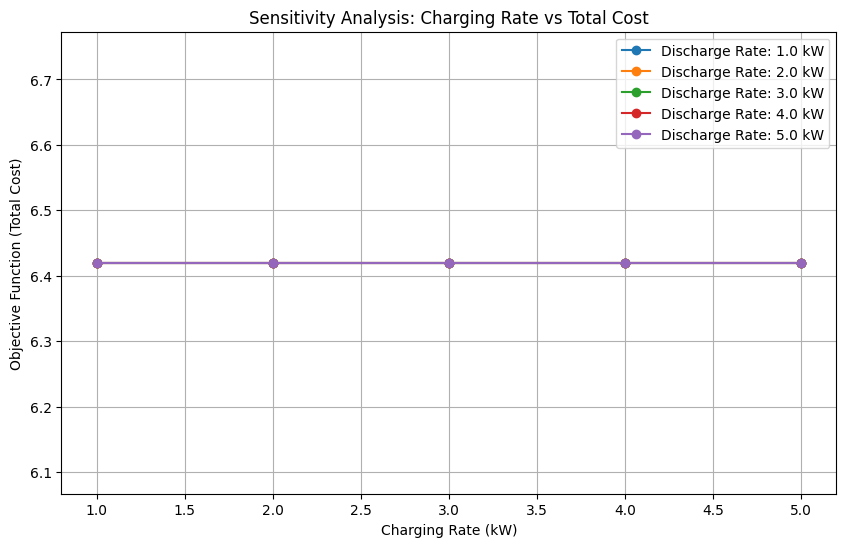

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp

# Define the range of charging and discharging rates to test
charging_rates = np.linspace(1.0, 5.0, 5)  # Charging rate from 1 to 5 kW (5 steps)
discharging_rates = np.linspace(1.0, 5.0, 5)  # Discharging rate from 1 to 5 kW (5 steps)

# Store results in a dictionary (key: discharge rate, value: list of (charge rate, objective function))
results = {}

# Loop through different discharging rates
for discharge_rate in discharging_rates:
    charge_results = []  # Store results for each discharge rate

    for charge_rate in charging_rates:
        # ✅ Update charge/discharge limits
        for t in time_periods:
            charge[t].ub = charge_rate  # Update charging rate upper bound
            discharge[t].ub = discharge_rate  # Update discharging rate upper bound

        # ✅ Solve the updated optimization model
        model.optimize()

        # ✅ Check Solver Status
        if model.status == gp.GRB.OPTIMAL:
            print(f"✅ Total Cost: {model.objVal} for Charge Rate = {charge_rate}, Discharge Rate = {discharge_rate}")
            charge_results.append((charge_rate, model.objVal))
        else:
            print(f"⚠️ Optimization failed for Charge Rate = {charge_rate}, Discharge Rate = {discharge_rate}")
            charge_results.append((charge_rate, None))  # Mark as failed

    results[discharge_rate] = charge_results  # Store results for this discharge rate

# ✅ Plot the results
plt.figure(figsize=(10, 6))

for discharge_rate, charge_results in results.items():
    charge_rates, obj_values = zip(*charge_results)  # Unzip the charge rates and costs
    obj_values = [val if val is not None else np.nan for val in obj_values]  # Handle failed cases

    plt.plot(charge_rates, obj_values, marker='o', linestyle='-', label=f"Discharge Rate: {discharge_rate} kW")

plt.xlabel("Charging Rate (kW)")
plt.ylabel("Objective Function (Total Cost)")
plt.title("Sensitivity Analysis: Charging Rate vs Total Cost")
plt.legend()
plt.grid(True)
plt.show()


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 49 rows, 120 columns and 190 nonzeros
Model fingerprint: 0x70c30b07
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [3e-01, 7e-01]
  Bounds range     [1e+00, 1e+06]
  RHS range        [6e-01, 4e+00]
Presolve removed 30 rows and 62 columns
Presolve time: 0.01s
Presolved: 19 rows, 58 columns, 76 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.3521660e+00   8.960526e+01   0.000000e+00      0s
       3    6.9946317e+00   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.994631667e+00
✅ Cost: 6.9946316668065265 | Charge Rate: 1.0 kW | Battery Capacity: 5.0 kWh
Gurobi Optimizer version 12.0.2 build v12.0.2r

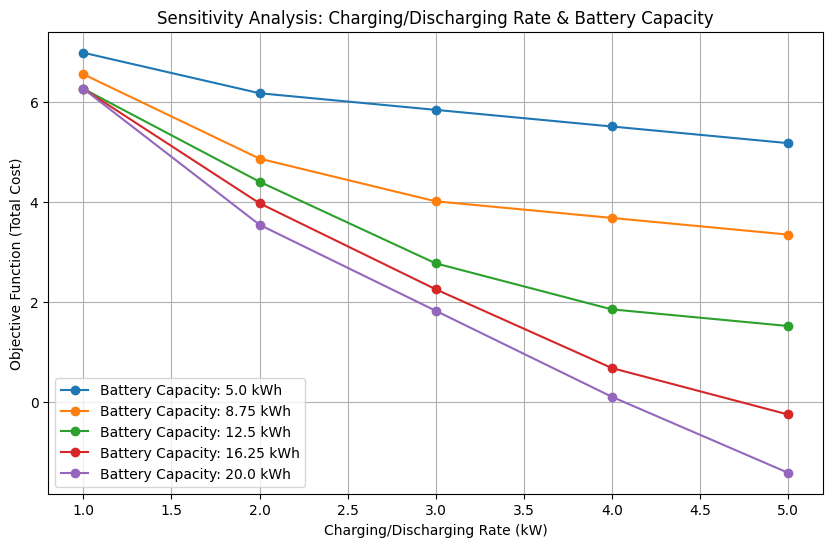

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp

# ✅ Define the range of charging/discharging rates & battery capacities to test
charge_discharge_rates = np.linspace(1.0, 5.0, 5)  # Charging/Discharging rate from 1 to 5 kW
battery_capacities = np.linspace(5, 20, 5)  # Battery capacity from 5 to 20 kWh

# ✅ Store results
results = []

# ✅ Loop through different battery capacities
for battery_capacity in battery_capacities:

    # Loop through different charge/discharge rates (keeping them equal)
    for rate in charge_discharge_rates:

        # ✅ Reinitialize the Gurobi model
        model = gp.Model("Energy_Optimization_Sensitivity")

        # ✅ Define decision variables with new charge/discharge limits and storage capacity
        charge = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=rate, name="charge")
        discharge = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=rate, name="discharge")
        battery_level = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=battery_capacity, name="battery_level")

        # ✅ Keep other decision variables the same
        PinG = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=1000000, name="PinG")
        PexG = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=1000000, name="PexG")

        # ✅ Objective Function: Minimize Total Cost
        model.setObjective(
            gp.quicksum(PRC[t] * (PinG[t] - PexG[t]) for t in time_periods),
            gp.GRB.MINIMIZE
        )

        # ✅ Constraints (same as before)
        for t in time_periods:
            model.addConstr(PinG[t] + discharge[t] + PV[t] == PexG[t] + charge[t] + PL[t])

            if t == 0:
                model.addConstr(battery_level[t] == 0.5 * battery_capacity)
            else:
                model.addConstr(battery_level[t] == battery_level[t - 1] + (charge[t] * 0.95) - (discharge[t] / 0.95))

            if t == 23:
                model.addConstr(battery_level[t] == 0.5 * battery_capacity)

        # ✅ Solve the model
        model.optimize()

        # ✅ Store results if the model is optimal
        if model.status == gp.GRB.OPTIMAL:
            print(f"✅ Cost: {model.objVal} | Charge Rate: {rate} kW | Battery Capacity: {battery_capacity} kWh")
            results.append((rate, battery_capacity, model.objVal))
        else:
            print(f"⚠️ Optimization failed for Charge Rate = {rate} kW, Battery Capacity = {battery_capacity} kWh")
            results.append((rate, battery_capacity, None))  # Mark as failed

# ✅ Convert results to NumPy array
results = np.array(results)

# ✅ Plot Sensitivity Analysis Results
plt.figure(figsize=(10, 6))

for battery_capacity in battery_capacities:
    rate_values = []
    obj_values = []

    for (rate, cap, cost) in results:
        if cap == battery_capacity:
            rate_values.append(rate)
            obj_values.append(cost if cost is not None else np.nan)

    plt.plot(rate_values, obj_values, marker='o', linestyle='-', label=f"Battery Capacity: {battery_capacity} kWh")

plt.xlabel("Charging/Discharging Rate (kW)")
plt.ylabel("Objective Function (Total Cost)")
plt.title("Sensitivity Analysis: Charging/Discharging Rate & Battery Capacity")
plt.legend()
plt.grid(True)
plt.show()


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 49 rows, 120 columns and 190 nonzeros
Model fingerprint: 0xfc393055
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e-01, 4e-01]
  Bounds range     [1e+00, 1e+06]
  RHS range        [3e-01, 4e+00]
Presolve removed 30 rows and 62 columns
Presolve time: 0.07s
Presolved: 19 rows, 58 columns, 76 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3747055e-01   4.875000e+01   0.000000e+00      0s
       8    4.4036862e+00   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.09 seconds (0.00 work units)
Optimal objective  4.403686233e+00
✅ Cost: 4.403686233388726 | Charge Rate: 1.0 kW | Battery Capacity: 5.0 kWh
Gurobi Optimizer version 12.0.1 build v12.0.1rc

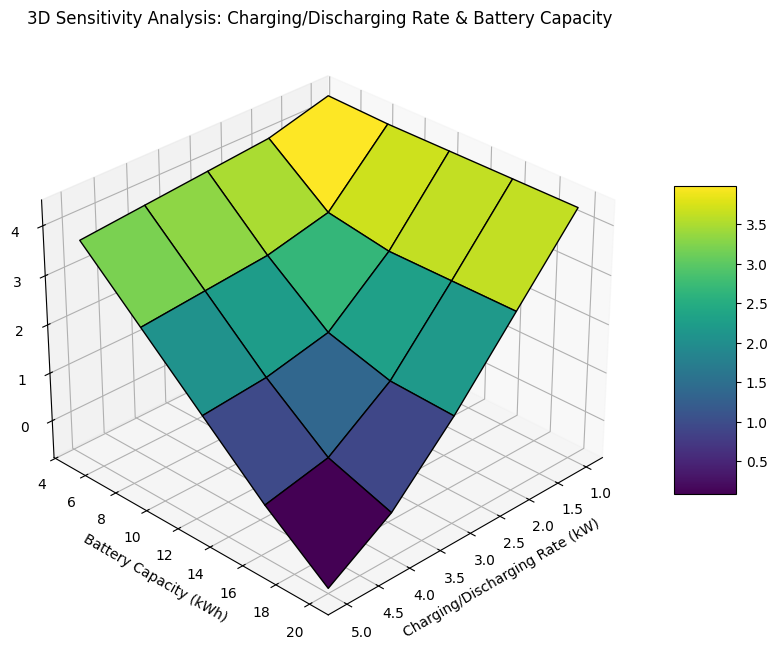

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from mpl_toolkits.mplot3d import Axes3D

# ✅ Define the range of charging/discharging rates & battery capacities to test
charge_discharge_rates = np.linspace(1.0, 5.0, 5)  # Charging/Discharging rate from 1 to 5 kW
battery_capacities = np.linspace(5, 20, 5)  # Battery capacity from 5 to 20 kWh

# ✅ Store results
results = []

# ✅ Loop through different battery capacities
for battery_capacity in battery_capacities:

    # Loop through different charge/discharge rates (keeping them equal)
    for rate in charge_discharge_rates:

        # ✅ Reinitialize the Gurobi model
        model = gp.Model("Energy_Optimization_Sensitivity")

        # ✅ Define decision variables with new charge/discharge limits and storage capacity
        charge = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=rate, name="charge")
        discharge = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=rate, name="discharge")
        battery_level = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=battery_capacity, name="battery_level")

        # ✅ Keep other decision variables the same
        PinG = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=1000000, name="PinG")
        PexG = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=1000000, name="PexG")

        # ✅ Objective Function: Minimize Total Cost
        model.setObjective(
            gp.quicksum(PRC[t] * (PinG[t] - PexG[t]) for t in time_periods),
            gp.GRB.MINIMIZE
        )

        # ✅ Constraints (same as before)
        for t in time_periods:
            model.addConstr(PinG[t] + discharge[t] + PV[t] == PexG[t] + charge[t] + PL[t])

            if t == 0:
                model.addConstr(battery_level[t] == 0.5 * battery_capacity)
            else:
                model.addConstr(battery_level[t] == battery_level[t - 1] + (charge[t] * 0.95) - (discharge[t] / 0.95))

            if t == 23:
                model.addConstr(battery_level[t] == 0.5 * battery_capacity)

        # ✅ Solve the model
        model.optimize()

        # ✅ Store results if the model is optimal
        if model.status == gp.GRB.OPTIMAL:
            print(f"✅ Cost: {model.objVal} | Charge Rate: {rate} kW | Battery Capacity: {battery_capacity} kWh")
            results.append((rate, battery_capacity, model.objVal))
        else:
            print(f"⚠️ Optimization failed for Charge Rate = {rate} kW, Battery Capacity = {battery_capacity} kWh")
            results.append((rate, battery_capacity, None))  # Mark as failed

# ✅ Convert results to NumPy arrays
rates = np.array([r[0] for r in results]).reshape(len(battery_capacities), len(charge_discharge_rates))
capacities = np.array([r[1] for r in results]).reshape(len(battery_capacities), len(charge_discharge_rates))
costs = np.array([r[2] if r[2] is not None else np.nan for r in results]).reshape(len(battery_capacities), len(charge_discharge_rates))

# ✅ Create a 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# ✅ Plot the surface
surf = ax.plot_surface(rates, capacities, costs, cmap='viridis', edgecolor='k')

# ✅ Label the axes
ax.set_xlabel("Charging/Discharging Rate (kW)")
ax.set_ylabel("Battery Capacity (kWh)")
ax.set_zlabel("Total Cost ($)")
ax.set_title("3D Sensitivity Analysis: Charging/Discharging Rate & Battery Capacity")

# ✅ Adjust the view angle (Modify these values to change perspective)
ax.view_init(elev=30, azim=45)  # Change elevation and azimuth angle

# ✅ Add color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

# ✅ Show the plot
plt.show()


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 49 rows, 120 columns and 190 nonzeros
Model fingerprint: 0xfc393055
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e-01, 4e-01]
  Bounds range     [1e+00, 1e+06]
  RHS range        [3e-01, 4e+00]
Presolve removed 30 rows and 62 columns
Presolve time: 0.08s
Presolved: 19 rows, 58 columns, 76 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.3747055e-01   4.875000e+01   0.000000e+00      0s
       8    4.4036862e+00   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.15 seconds (0.00 work units)
Optimal objective  4.403686233e+00
✅ Cost: 4.403686233388726 | Charge Rate: 1.0 kW | Battery Capacity: 5.0 kWh
Gurobi Optimizer version 12.0.1 build v12.0.1rc

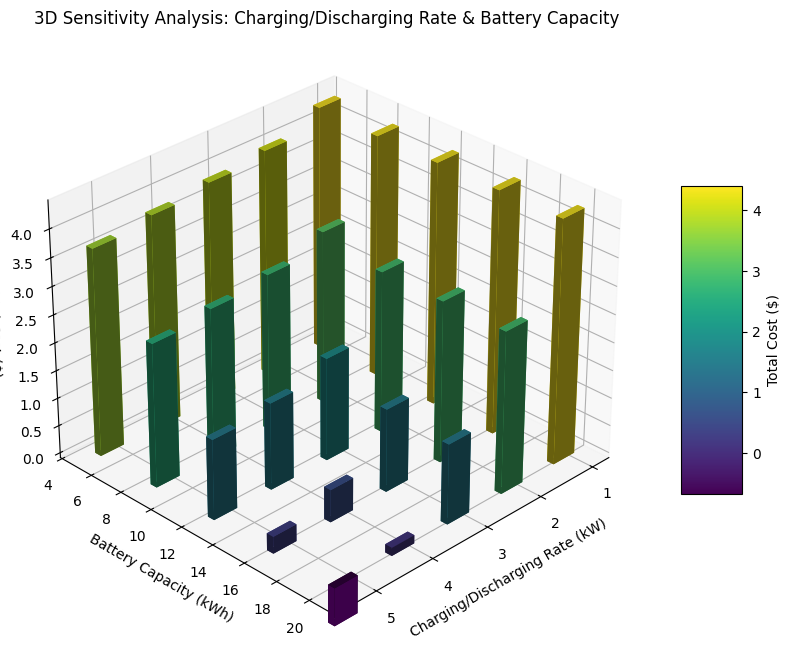

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# ✅ Define the range of charging/discharging rates & battery capacities
charge_discharge_rates = np.linspace(1.0, 5.0, 5)  # Charging/Discharging rate from 1 to 5 kW
battery_capacities = np.linspace(5, 20, 5)  # Battery capacity from 5 to 20 kWh

# ✅ Store results
results = []

# ✅ Loop through different battery capacities
for battery_capacity in battery_capacities:
    for rate in charge_discharge_rates:

        # ✅ Reinitialize the Gurobi model
        model = gp.Model("Energy_Optimization_Sensitivity")

        # ✅ Define decision variables with new charge/discharge limits and storage capacity
        charge = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=rate, name="charge")
        discharge = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=rate, name="discharge")
        battery_level = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=battery_capacity, name="battery_level")

        # ✅ Keep other decision variables the same
        PinG = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=1000000, name="PinG")
        PexG = model.addVars(time_periods, vtype=gp.GRB.CONTINUOUS, lb=0, ub=1000000, name="PexG")

        # ✅ Objective Function: Minimize Total Cost
        model.setObjective(
            gp.quicksum(PRC[t] * (PinG[t] - PexG[t]) for t in time_periods),
            gp.GRB.MINIMIZE
        )

        # ✅ Constraints (same as before)
        for t in time_periods:
            model.addConstr(PinG[t] + discharge[t] + PV[t] == PexG[t] + charge[t] + PL[t])

            if t == 0:
                model.addConstr(battery_level[t] == 0.5 * battery_capacity)
            else:
                model.addConstr(battery_level[t] == battery_level[t - 1] + (charge[t] * 0.95) - (discharge[t] / 0.95))

            if t == 23:
                model.addConstr(battery_level[t] == 0.5 * battery_capacity)

        # ✅ Solve the model
        model.optimize()

        # ✅ Store results if the model is optimal
        if model.status == gp.GRB.OPTIMAL:
            print(f"✅ Cost: {model.objVal} | Charge Rate: {rate} kW | Battery Capacity: {battery_capacity} kWh")
            results.append((rate, battery_capacity, model.objVal))
        else:
            print(f"⚠️ Optimization failed for Charge Rate = {rate} kW, Battery Capacity = {battery_capacity} kWh")
            results.append((rate, battery_capacity, None))  # Mark as failed

# ✅ Convert results to NumPy arrays
rates = np.array([r[0] for r in results])
capacities = np.array([r[1] for r in results])
costs = np.array([r[2] if r[2] is not None else np.nan for r in results])

# ✅ Normalize cost values for color mapping
costs_min, costs_max = np.nanmin(costs), np.nanmax(costs)  # Get min and max cost
norm_costs = (costs - costs_min) / (costs_max - costs_min)  # Normalize to [0,1]
colors = cm.viridis(norm_costs)  # Apply colormap

# ✅ Define square base size
square_size = 0.4  # Adjust to keep bars proportional

# ✅ Create a 3D Bar Chart
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# ✅ Plot bars with square bases
ax.bar3d(rates, capacities, np.zeros_like(costs), square_size, square_size, costs, color=colors, shade=True)

# ✅ Set labels
ax.set_xlabel("Charging/Discharging Rate (kW)")
ax.set_ylabel("Battery Capacity (kWh)")
ax.set_zlabel("Total Cost ($)")
ax.set_title("3D Sensitivity Analysis: Charging/Discharging Rate & Battery Capacity")

# ✅ Add color bar
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=costs_min, vmax=costs_max))
fig.colorbar(sm, ax=ax, shrink=0.5, aspect=5).set_label("Total Cost ($)")

# ✅ Adjust the view angle (Modify these values to change perspective)
ax.view_init(elev=30, azim=45)  # Change elevation and azimuth angle

# ✅ Show the plot
plt.show()


In [ ]:
# ✅ Convert results into a Pandas DataFrame
df_results = pd.DataFrame(results, columns=["Charging/Discharging Rate (kW)", "Battery Capacity (kWh)", "Total Cost ($)"])

# ✅ Export results to an Excel file
excel_filename = "/content/Optimization_Results.xlsx"  # Adjust path if necessary
df_results.to_excel(excel_filename, index=False)

print(f"✅ Results saved to {excel_filename}")
from google.colab import files
files.download("/content/Optimization_Results.xlsx")

✅ Results saved to /content/Optimization_Results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>